## Linear-regression-model-for-identifying-factors-affecting-car-prices

## A. Importing libraries and other preliminaries

In [0]:
# Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,r2_score
import math
from operator import itemgetter
from sklearn.feature_selection import RFE

# Setting defaults for pandas
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

## B. Custom functions

In [0]:
# Function to normalize
def normalize(x):
    return (x-x.mean()/(max(x)-min(x)))

In [0]:
# Function to calculate Variance Inflation Factor (VIF)
def vif(data, dep_col):
    data=data.drop([dep_col], axis=1)
    vif_df=pd.DataFrame(columns=['Variable', 'VIF'])
    
    for i, col in enumerate(data.columns):
        y=data[col]
        x=data.drop(col, axis=1)
        r2_score=sm.OLS(y,x).fit().rsquared
        vif=round(1/(1-(r2_score)**2))
        vif_df.loc[i]=[col, vif]
        
    return vif_df.sort_values(by='VIF', ascending=False)

In [0]:
# Function to return dummy variables
def dummy(data, cols):
    dummy_df=pd.get_dummies(data[cols], drop_first=True)
    df=pd.concat([data, dummy_df], axis=1)
    df.drop(cols, axis=1, inplace=True)
    return df

## 1. Exploratory data analysis

### 1.1 Importing the data

In [0]:
car=pd.read_csv("CarPrice_Assignment.csv")
car.head()

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,carheight,curbweight,enginetype,cylindernumber,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,six,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,four,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,five,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


### 1.2 Meta data and statistical measures

In [0]:
car.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
car_ID              205 non-null int64
symboling           205 non-null int64
CarName             205 non-null object
fueltype            205 non-null object
aspiration          205 non-null object
doornumber          205 non-null object
carbody             205 non-null object
drivewheel          205 non-null object
enginelocation      205 non-null object
wheelbase           205 non-null float64
carlength           205 non-null float64
carwidth            205 non-null float64
carheight           205 non-null float64
curbweight          205 non-null int64
enginetype          205 non-null object
cylindernumber      205 non-null object
enginesize          205 non-null int64
fuelsystem          205 non-null object
boreratio           205 non-null float64
stroke              205 non-null float64
compressionratio    205 non-null float64
horsepower          205 non-null int64
peakrpm      

Setting 'car_ID' as index

In [0]:
car.set_index('car_ID')

,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,carheight,curbweight,enginetype,cylindernumber,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
car_ID,,,,,,,,,,,,,,,,,,,,,,,,,
1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.680,9.00,111,5000,21,27,13495.000
2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.680,9.00,111,5000,21,27,16500.000
3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,six,152,mpfi,2.68,3.470,9.00,154,5000,19,26,16500.000
4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,four,109,mpfi,3.19,3.400,10.00,102,5500,24,30,13950.000
5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,five,136,mpfi,3.19,3.400,8.00,115,5500,18,22,17450.000
6,2,audi fox,gas,std,two,sedan,fwd,front,99.8,177.3,66.3,53.1,2507,ohc,five,136,mpfi,3.19,3.400,8.50,110,5500,19,25,15250.000
7,1,audi 100ls,gas,std,four,sedan,fwd,front,105.8,192.7,71.4,55.7,2844,ohc,five,136,mpfi,3.19,3.400,8.50,110,5500,19,25,17710.000
8,1,audi 5000,gas,std,four,wagon,fwd,front,105.8,192.7,71.4,55.7,2954,ohc,five,136,mpfi,3.19,3.400,8.50,110,5500,19,25,18920.000
9,1,audi 4000,gas,turbo,four,sedan,fwd,front,105.8,192.7,71.4,55.9,3086,ohc,five,131,mpfi,3.13,3.400,8.30,140,5500,17,20,23875.000


### 1.3 Data cleaning

Checking for null values

In [0]:
car.isnull().any(axis=1).sum()

0

Proceeding to next steps since no null values found

### 1.4 Column analysis

Printing columns that have 'object' data type to see if any numeric type column is present

In [0]:
car.select_dtypes(include=[object]).head()

,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,enginetype,cylindernumber,fuelsystem
0,alfa-romero giulia,gas,std,two,convertible,rwd,front,dohc,four,mpfi
1,alfa-romero stelvio,gas,std,two,convertible,rwd,front,dohc,four,mpfi
2,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,ohcv,six,mpfi
3,audi 100 ls,gas,std,four,sedan,fwd,front,ohc,four,mpfi
4,audi 100ls,gas,std,four,sedan,4wd,front,ohc,five,mpfi


Since all columns with data type 'object' are strings, there is no need to change there data type

Updating the CarName column to contain only the company name

In [0]:
car['CarName']=car.CarName.str.split(" ").str.get(0)

Creating a list of all category and string columns

In [0]:
CatColumns_list=car.select_dtypes(include=['object']).columns.tolist()
CatColumns_list

['CarName',
 'fueltype',
 'aspiration',
 'doornumber',
 'carbody',
 'drivewheel',
 'enginelocation',
 'enginetype',
 'cylindernumber',
 'fuelsystem']

Appending 'symboling' to this list as it is also a categorical variable but not of type 'object'

In [0]:
car['symboling']=car['symboling'].astype('str')

In [0]:
CatColumns_list.append('symboling')
CatColumns_list

['CarName',
 'fueltype',
 'aspiration',
 'doornumber',
 'carbody',
 'drivewheel',
 'enginelocation',
 'enginetype',
 'cylindernumber',
 'fuelsystem',
 'symboling']

Converting all categorical columns to dummy variables and checking the result

In [0]:
car_dummy=dummy(car, CatColumns_list)
car_dummy.head()

,car_ID,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price,CarName_alfa-romero,CarName_audi,CarName_bmw,CarName_buick,CarName_chevrolet,CarName_dodge,CarName_honda,CarName_isuzu,CarName_jaguar,CarName_maxda,CarName_mazda,CarName_mercury,CarName_mitsubishi,CarName_nissan,CarName_peugeot,CarName_plymouth,CarName_porcshce,CarName_porsche,CarName_renault,CarName_saab,CarName_subaru,CarName_toyota,CarName_toyouta,CarName_vokswagen,CarName_volkswagen,CarName_volvo,CarName_vw,fueltype_gas,aspiration_turbo,doornumber_two,carbody_hardtop,carbody_hatchback,carbody_sedan,carbody_wagon,drivewheel_fwd,drivewheel_rwd,enginelocation_rear,enginetype_dohcv,enginetype_l,enginetype_ohc,enginetype_ohcf,enginetype_ohcv,enginetype_rotor,cylindernumber_five,cylindernumber_four,cylindernumber_six,cylindernumber_three,cylindernumber_twelve,cylindernumber_two,fuelsystem_2bbl,fuelsystem_4bbl,fuelsystem_idi,fuelsystem_mfi,fuelsystem_mpfi,fuelsystem_spdi,fuelsystem_spfi,symboling_-2,symboling_0,symboling_1,symboling_2,symboling_3
0,1,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,111,5000,21,27,13495.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
1,2,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,111,5000,21,27,16500.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
2,3,94.5,171.2,65.5,52.4,2823,152,2.68,3.47,9.0,154,5000,19,26,16500.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
3,4,99.8,176.6,66.2,54.3,2337,109,3.19,3.40,10.0,102,5500,24,30,13950.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
4,5,99.4,176.6,66.4,54.3,2824,136,3.19,3.40,8.0,115,5500,18,22,17450.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0


As can be seen from above, various car names have been misspelled. Correcting these and creating another dataframe with dummy variables

In [0]:
car.CarName.replace(['vokswagen', 'vw', 'toyouta', 'maxda', 'porcshce'], ['volkswagen', 'volkswagen', 'toyota','mazda', 'porsche'], inplace=True)
car_dummy=dummy(car, CatColumns_list)
car_dummy.head()

,car_ID,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price,CarName_alfa-romero,CarName_audi,CarName_bmw,CarName_buick,CarName_chevrolet,CarName_dodge,CarName_honda,CarName_isuzu,CarName_jaguar,CarName_mazda,CarName_mercury,CarName_mitsubishi,CarName_nissan,CarName_peugeot,CarName_plymouth,CarName_porsche,CarName_renault,CarName_saab,CarName_subaru,CarName_toyota,CarName_volkswagen,CarName_volvo,fueltype_gas,aspiration_turbo,doornumber_two,carbody_hardtop,carbody_hatchback,carbody_sedan,carbody_wagon,drivewheel_fwd,drivewheel_rwd,enginelocation_rear,enginetype_dohcv,enginetype_l,enginetype_ohc,enginetype_ohcf,enginetype_ohcv,enginetype_rotor,cylindernumber_five,cylindernumber_four,cylindernumber_six,cylindernumber_three,cylindernumber_twelve,cylindernumber_two,fuelsystem_2bbl,fuelsystem_4bbl,fuelsystem_idi,fuelsystem_mfi,fuelsystem_mpfi,fuelsystem_spdi,fuelsystem_spfi,symboling_-2,symboling_0,symboling_1,symboling_2,symboling_3
0,1,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,111,5000,21,27,13495.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
1,2,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,111,5000,21,27,16500.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
2,3,94.5,171.2,65.5,52.4,2823,152,2.68,3.47,9.0,154,5000,19,26,16500.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
3,4,99.8,176.6,66.2,54.3,2337,109,3.19,3.40,10.0,102,5500,24,30,13950.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
4,5,99.4,176.6,66.4,54.3,2824,136,3.19,3.40,8.0,115,5500,18,22,17450.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0


## 2. Building a linear regression model

Normalizing all data

In [0]:
car_dummy.head()

,car_ID,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price,CarName_alfa-romero,CarName_audi,CarName_bmw,CarName_buick,CarName_chevrolet,CarName_dodge,CarName_honda,CarName_isuzu,CarName_jaguar,CarName_mazda,CarName_mercury,CarName_mitsubishi,CarName_nissan,CarName_peugeot,CarName_plymouth,CarName_porsche,CarName_renault,CarName_saab,CarName_subaru,CarName_toyota,CarName_volkswagen,CarName_volvo,fueltype_gas,aspiration_turbo,doornumber_two,carbody_hardtop,carbody_hatchback,carbody_sedan,carbody_wagon,drivewheel_fwd,drivewheel_rwd,enginelocation_rear,enginetype_dohcv,enginetype_l,enginetype_ohc,enginetype_ohcf,enginetype_ohcv,enginetype_rotor,cylindernumber_five,cylindernumber_four,cylindernumber_six,cylindernumber_three,cylindernumber_twelve,cylindernumber_two,fuelsystem_2bbl,fuelsystem_4bbl,fuelsystem_idi,fuelsystem_mfi,fuelsystem_mpfi,fuelsystem_spdi,fuelsystem_spfi,symboling_-2,symboling_0,symboling_1,symboling_2,symboling_3
0,1,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,111,5000,21,27,13495.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
1,2,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,111,5000,21,27,16500.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
2,3,94.5,171.2,65.5,52.4,2823,152,2.68,3.47,9.0,154,5000,19,26,16500.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
3,4,99.8,176.6,66.2,54.3,2337,109,3.19,3.40,10.0,102,5500,24,30,13950.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
4,5,99.4,176.6,66.4,54.3,2824,136,3.19,3.40,8.0,115,5500,18,22,17450.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0


In [0]:
car_dummy=car_dummy.apply(normalize)
car_dummy.head()

,car_ID,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price,CarName_alfa-romero,CarName_audi,CarName_bmw,CarName_buick,CarName_chevrolet,CarName_dodge,CarName_honda,CarName_isuzu,CarName_jaguar,CarName_mazda,CarName_mercury,CarName_mitsubishi,CarName_nissan,CarName_peugeot,CarName_plymouth,CarName_porsche,CarName_renault,CarName_saab,CarName_subaru,CarName_toyota,CarName_volkswagen,CarName_volvo,fueltype_gas,aspiration_turbo,doornumber_two,carbody_hardtop,carbody_hatchback,carbody_sedan,carbody_wagon,drivewheel_fwd,drivewheel_rwd,enginelocation_rear,enginetype_dohcv,enginetype_l,enginetype_ohc,enginetype_ohcf,enginetype_ohcv,enginetype_rotor,cylindernumber_five,cylindernumber_four,cylindernumber_six,cylindernumber_three,cylindernumber_twelve,cylindernumber_two,fuelsystem_2bbl,fuelsystem_4bbl,fuelsystem_idi,fuelsystem_mfi,fuelsystem_mpfi,fuelsystem_spdi,fuelsystem_spfi,symboling_-2,symboling_0,symboling_1,symboling_2,symboling_3
0,0.495098,85.720799,166.20225,58.607683,44.322927,2547.008702,129.521104,1.091603,1.129803,8.366091,110.566179,4997.908113,20.299458,26.190757,13494.670406,0.985366,-0.034146,-0.039024,-0.039024,-0.014634,-0.043902,-0.063415,-0.019512,-0.014634,-0.082927,-0.004878,-0.063415,-0.082927,-0.053659,-0.034146,-0.02439,-0.009756,-0.029268,-0.058537,-0.156098,-0.058537,-0.053659,0.097561,-0.180488,0.560976,-0.039024,-0.341463,-0.468293,-0.121951,-0.585366,0.629268,-0.014634,-0.004878,-0.058537,-0.721951,-0.073171,-0.063415,-0.019512,-0.053659,0.22439,-0.117073,-0.004878,-0.004878,-0.019512,-0.321951,-0.014634,-0.097561,-0.004878,0.541463,-0.043902,-0.004878,-0.014634,-0.326829,-0.263415,-0.156098,0.868293
1,1.495098,85.720799,166.20225,58.607683,44.322927,2547.008702,129.521104,1.091603,1.129803,8.366091,110.566179,4997.908113,20.299458,26.190757,16499.670406,0.985366,-0.034146,-0.039024,-0.039024,-0.014634,-0.043902,-0.063415,-0.019512,-0.014634,-0.082927,-0.004878,-0.063415,-0.082927,-0.053659,-0.034146,-0.02439,-0.009756,-0.029268,-0.058537,-0.156098,-0.058537,-0.053659,0.097561,-0.180488,0.560976,-0.039024,-0.341463,-0.468293,-0.121951,-0.585366,0.629268,-0.014634,-0.004878,-0.058537,-0.721951,-0.073171,-0.063415,-0.019512,-0.053659,0.22439,-0.117073,-0.004878,-0.004878,-0.019512,-0.321951,-0.014634,-0.097561,-0.004878,0.541463,-0.043902,-0.004878,-0.014634,-0.326829,-0.263415,-0.156098,0.868293
2,2.495098,91.620799,168.60225,60.007683,47.922927,2822.008702,151.521104,0.301603,1.919803,8.366091,153.566179,4997.908113,18.299458,25.190757,16499.670406,0.985366,-0.034146,-0.039024,-0.039024,-0.014634,-0.043902,-0.063415,-0.019512,-0.014634,-0.082927,-0.004878,-0.063415,-0.082927,-0.053659,-0.034146,-0.02439,-0.009756,-0.029268,-0.058537,-0.156098,-0.058537,-0.053659,0.097561,-0.180488,0.560976,-0.039024,0.658537,-0.468293,-0.121951,-0.585366,0.629268,-0.014634,-0.004878,-0.058537,-0.721951,-0.073171,0.936585,-0.019512,-0.053659,-0.77561,0.882927,-0.004878,-0.004878,-0.019512,-0.321951,-0.014634,-0.097561,-0.004878,0.541463,-0.043902,-0.004878,-0.014634,-0.326829,0.736585,-0.156098,-0.131707
3,3.495098,96.920799,174.00225,60.707683,49.822927,2336.008702,108.521104,0.811603,1.849803,9.366091,101.566179,5497.908113,23.299458,29.190757,13949.670406,-0.014634,0.965854,-0.039024,-0.039024,-0.014634,-0.043902,-0.063415,-0.019512,-0.014634,-0.082927,-0.004878,-0.063415,-0.082927,-0.053659,-0.034146,-0.02439,-0.009756,-0.029268,-0.058537,-0.156098,-0.058537,-0.053659,0.097561,-0.180488,-0.439024,-0.039024,-0.341463,0.531707,-0.121951,0.414634,-0.370732,-0.014634,-0.004878,-0.058537,0.278049,-0.073171,-0.063415,-0.019512,-0.053659,0.22439,-0.117073,-0.004878,-0.004878,-0.019512,-0.321951,-0.014634,-0.097561,-0.004878,0.541463,-0.043902,-0.004878,-0.014634,-0.326829,-0.263415,0.843902,-0.131707
4,4.495098,96.520799,174.00225,60.907683,49.822927,2823.008702,135.521104,0.811603,1.849803,7.366091,114.566179,5497.908113,17.299458,21.19075

Creating a linear regression object and splitting data into test and training data

In [0]:
lr=LinearRegression()
X=car_dummy.loc[:, car_dummy.columns!='price']
y=car_dummy.price
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.3, train_size=0.7, random_state=1)

Using RFE to narrow down on features

In [0]:
rfe=RFE(lr, 15)
rfe=rfe.fit(X_train.iloc[:,1:], y_train)
X_train.loc[:,~rfe.support_]

,car_ID,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,CarName_buick,CarName_chevrolet,CarName_dodge,CarName_honda,CarName_jaguar,CarName_mazda,CarName_mercury,CarName_mitsubishi,CarName_nissan,CarName_peugeot,CarName_porsche,CarName_saab,CarName_subaru,CarName_toyota,CarName_volkswagen,CarName_volvo,fueltype_gas,aspiration_turbo,doornumber_two,carbody_hardtop,carbody_hatchback,carbody_sedan,carbody_wagon,enginelocation_rear,enginetype_dohcv,enginetype_l,enginetype_ohcf,cylindernumber_six,cylindernumber_three,cylindernumber_two,fuelsystem_4bbl,fuelsystem_idi,fuelsystem_mfi,fuelsystem_mpfi,fuelsystem_spdi,fuelsystem_spfi,symboling_-2,symboling_0,symboling_1,symboling_2
124,124.495098,93.020799,170.60225,60.807683,45.722927,2817.008702,155.521104,1.211603,2.309803,6.366091,144.566179,4997.908113,18.299458,23.190757,-0.039024,-0.014634,-0.043902,-0.063415,-0.014634,-0.082927,-0.004878,-0.063415,-0.082927,-0.053659,-0.02439,-0.029268,-0.058537,-0.156098,-0.058537,-0.053659,0.097561,0.819512,0.560976,-0.039024,0.658537,-0.468293,-0.121951,-0.014634,-0.004878,-0.058537,-0.073171,-0.117073,-0.004878,-0.019512,-0.014634,-0.097561,-0.004878,-0.458537,0.956098,-0.004878,-0.014634,-0.326829,-0.263415,-0.156098
181,181.495098,101.620799,185.20225,61.007683,49.622927,3150.008702,160.521104,0.891603,1.799803,8.566091,155.566179,5197.908113,18.299458,23.190757,-0.039024,-0.014634,-0.043902,-0.063415,-0.014634,-0.082927,-0.004878,-0.063415,-0.082927,-0.053659,-0.02439,-0.029268,-0.058537,0.843902,-0.058537,-0.053659,0.097561,-0.180488,-0.439024,-0.039024,-0.341463,-0.468293,0.878049,-0.014634,-0.004878,-0.058537,-0.073171,0.882927,-0.004878,-0.019512,-0.014634,-0.097561,-0.004878,0.541463,-0.043902,-0.004878,-0.014634,-0.326829,-0.263415,-0.156098
154,154.495098,92.820799,167.10225,58.107683,54.622927,2289.008702,91.521104,0.671603,1.479803,8.366091,61.566179,4797.908113,26.299458,31.190757,-0.039024,-0.014634,-0.043902,-0.063415,-0.014634,-0.082927,-0.004878,-0.063415,-0.082927,-0.053659,-0.02439,-0.029268,-0.058537,0.843902,-0.058537,-0.053659,0.097561,-0.180488,-0.439024,-0.039024,-0.341463,-0.468293,0.878049,-0.014634,-0.004878,-0.058537,-0.073171,-0.117073,-0.004878,-0.019512,-0.014634,-0.097561,-0.004878,-0.458537,-0.043902,-0.004878,-0.014634,0.673171,-0.263415,-0.156098
53,53.495098,90.220799,164.20225,58.707683,49.622927,1944.008702,90.521104,0.651603,1.599803,8.366091,67.566179,4997.908113,30.299458,37.190757,-0.039024,-0.014634,-0.043902,-0.063415,-0.014634,0.917073,-0.004878,-0.063415,-0.082927,-0.053659,-0.02439,-0.029268,-0.058537,-0.156098,-0.058537,-0.053659,0.097561,-0.180488,-0.439024,-0.039024,-0.341463,0.531707,-0.121951,-0.014634,-0.004878,-0.058537,-0.073171,-0.117073,-0.004878,-0.019512,-0.014634,-0.097561,-0.004878,-0.458537,-0.043902,-0.004878,-0.014634,-0.326829,0.736585,-0.156098
94,94.495098,91.620799,162.70225,58.307683,50.022927,1950.008702,96.521104,0.771603,1.739803,8.766091,68.566179,5197.908113,30.299458,36.190757,-0.039024,-0.014634,-0.043902,-0.063415,-0.014634,-0.082927,-0.004878,-0.063415,0.917073,-0.053659,-0.02439,-0.029268,-0.058537,-0.156098,-0.058537,-0.053659,0.097561,-0.180488,0.560976,-0.039024,-0.341463,0.531707,-0.121951,-0.014634,-0.004878,-0.058537,-0.073171,-0.117073,-0.004878,-0.019512,-0.014634,-0.097561,-0.004878,-0.458537,-0.043902,-0.004878,-0.014634,-0.326829,0.736585,-0.156098
143,143.495098,94.320799,169.40225,59.907683,48.022927,2339.008702,107.521104,1.241603,1.089803,8.366091,93.566179,5197.908113,25.299458,31.190757,-0.039024,-0.014634,-0.043902,-0.063415,-0.014634,-0.082927,-0.004878,-0.063415,-0.082927,-0.053659,-0.02439,-0.029268,0.941463,-0.156098,-0.058537,-0.053659,0.097561,-0.180488,-0.439024,-0.039024,-0.341463,0.531707,-0.121951,-0.014634,-0.004878,-0.058537,0.926829,-0.117073,-0.004878,-0.019512,-0.014634,-0.097561,-0.004878,0.541463,-0.043902,-0.004878,-0.014634,0.673171,-0.263415,-0.1

Updating the 'car_dummy' dataframe to select only the columns selected above by RFE and creating a new test and train data set for further analysis with statsmodels.api

In [0]:
cols_drop=X_train.loc[:,~rfe.support_]
car_dummy.drop(cols_drop.columns.tolist(), axis=1, inplace=True)
car_dummy.head()

,price,CarName_alfa-romero,CarName_audi,CarName_bmw,CarName_isuzu,CarName_plymouth,CarName_renault,drivewheel_fwd,drivewheel_rwd,enginetype_ohc,enginetype_ohcv,enginetype_rotor,cylindernumber_five,cylindernumber_four,cylindernumber_twelve,fuelsystem_2bbl,symboling_3
0,13494.670406,0.985366,-0.034146,-0.039024,-0.019512,-0.034146,-0.009756,-0.585366,0.629268,-0.721951,-0.063415,-0.019512,-0.053659,0.22439,-0.004878,-0.321951,0.868293
1,16499.670406,0.985366,-0.034146,-0.039024,-0.019512,-0.034146,-0.009756,-0.585366,0.629268,-0.721951,-0.063415,-0.019512,-0.053659,0.22439,-0.004878,-0.321951,0.868293
2,16499.670406,0.985366,-0.034146,-0.039024,-0.019512,-0.034146,-0.009756,-0.585366,0.629268,-0.721951,0.936585,-0.019512,-0.053659,-0.77561,-0.004878,-0.321951,-0.131707
3,13949.670406,-0.014634,0.965854,-0.039024,-0.019512,-0.034146,-0.009756,0.414634,-0.370732,0.278049,-0.063415,-0.019512,-0.053659,0.22439,-0.004878,-0.321951,-0.131707
4,17449.670406,-0.014634,0.965854,-0.039024,-0.019512,-0.034146,-0.009756,-0.585366,-0.370732,0.278049,-0.063415,-0.019512,0.946341,-0.77561,-0.004878,-0.321951,-0.131707


In [0]:
X=car_dummy.loc[:, car_dummy.columns!='price']
y=car_dummy.price
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.3, train_size=0.7, random_state=1)

In [0]:
X_train.reset_index(inplace=True)
y_train=y_train.reset_index()

In [0]:
X_train=sm.add_constant(X_train, prepend=True, has_constant="add")
X_train.head()

,const,index,CarName_alfa-romero,CarName_audi,CarName_bmw,CarName_isuzu,CarName_plymouth,CarName_renault,drivewheel_fwd,drivewheel_rwd,enginetype_ohc,enginetype_ohcv,enginetype_rotor,cylindernumber_five,cylindernumber_four,cylindernumber_twelve,fuelsystem_2bbl,symboling_3
0,1.0,124,-0.014634,-0.034146,-0.039024,-0.019512,0.965854,-0.009756,-0.585366,0.629268,0.278049,-0.063415,-0.019512,-0.053659,0.22439,-0.004878,-0.321951,0.868293
1,1.0,181,-0.014634,-0.034146,-0.039024,-0.019512,-0.034146,-0.009756,-0.585366,0.629268,-0.721951,-0.063415,-0.019512,-0.053659,-0.77561,-0.004878,-0.321951,-0.131707
2,1.0,154,-0.014634,-0.034146,-0.039024,-0.019512,-0.034146,-0.009756,-0.585366,-0.370732,0.278049,-0.063415,-0.019512,-0.053659,0.22439,-0.004878,0.678049,-0.131707
3,1.0,53,-0.014634,-0.034146,-0.039024,-0.019512,-0.034146,-0.009756,0.414634,-0.370732,0.278049,-0.063415,-0.019512,-0.053659,0.22439,-0.004878,0.678049,-0.131707
4,1.0,94,-0.014634,-0.034146,-0.039024,-0.019512,-0.034146,-0.009756,0.414634,-0.370732,0.278049,-0.063415,-0.019512,-0.053659,0.22439,-0.004878,0.678049,-0.131707


Running Linear Regression using statsmodels

### Model 1

In [0]:
lm_1=sm.OLS(y_train['price'],X_train.iloc[:,X_train.columns!='index']).fit()
print(lm_1.summary())
lm_1

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.725
Model:                            OLS   Adj. R-squared:                  0.690
Method:                 Least Squares   F-statistic:                     20.79
Date:                Sun, 24 Jun 2018   Prob (F-statistic):           5.90e-28
Time:                        21:23:35   Log-Likelihood:                -1396.4
No. Observations:                 143   AIC:                             2827.
Df Residuals:                     126   BIC:                             2877.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  1.329e+

In [0]:
vif(data=car_dummy, dep_col="price")

,Variable,VIF
6,drivewheel_fwd,4.0
7,drivewheel_rwd,4.0
11,cylindernumber_five,2.0
12,cylindernumber_four,2.0
0,CarName_alfa-romero,1.0
1,CarName_audi,1.0
2,CarName_bmw,1.0
3,CarName_isuzu,1.0
4,CarName_plymouth,1.0
5,CarName_renault,1.0


Dropping the column 'CarName_renault' as it has a very high p-value of 0.965 and rebuilding the model

### Model 2

In [0]:
X_train.drop('CarName_renault', axis=1, inplace=True)
car_dummy.drop('CarName_renault', axis=1, inplace=True)
lm_2=sm.OLS(y_train['price'],X_train.iloc[:,X_train.columns!='index']).fit()
print(lm_2.summary())
vif(car_dummy, 'price')

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.725
Model:                            OLS   Adj. R-squared:                  0.693
Method:                 Least Squares   F-statistic:                     22.35
Date:                Sun, 24 Jun 2018   Prob (F-statistic):           1.22e-28
Time:                        21:23:35   Log-Likelihood:                -1396.4
No. Observations:                 143   AIC:                             2825.
Df Residuals:                     127   BIC:                             2872.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  1.329e+

,Variable,VIF
5,drivewheel_fwd,4.0
6,drivewheel_rwd,4.0
10,cylindernumber_five,2.0
11,cylindernumber_four,2.0
0,CarName_alfa-romero,1.0
1,CarName_audi,1.0
2,CarName_bmw,1.0
3,CarName_isuzu,1.0
4,CarName_plymouth,1.0
7,enginetype_ohc,1.0


Dropping the column 'enginetype_ohcv' as it has a very high p-value of 0.920 and rebuilding the model

### Model 3

In [0]:
X_train.drop('enginetype_ohcv', axis=1, inplace=True)
car_dummy.drop('enginetype_ohcv', axis=1, inplace=True)
lm_3=sm.OLS(y_train['price'],X_train.iloc[:,X_train.columns!='index']).fit()
print(lm_3.summary())
vif(car_dummy, 'price')

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.725
Model:                            OLS   Adj. R-squared:                  0.695
Method:                 Least Squares   F-statistic:                     24.12
Date:                Sun, 24 Jun 2018   Prob (F-statistic):           2.50e-29
Time:                        21:23:35   Log-Likelihood:                -1396.4
No. Observations:                 143   AIC:                             2823.
Df Residuals:                     128   BIC:                             2867.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  1.329e+

,Variable,VIF
5,drivewheel_fwd,4.0
6,drivewheel_rwd,4.0
9,cylindernumber_five,2.0
10,cylindernumber_four,2.0
0,CarName_alfa-romero,1.0
1,CarName_audi,1.0
2,CarName_bmw,1.0
3,CarName_isuzu,1.0
4,CarName_plymouth,1.0
7,enginetype_ohc,1.0


Dropping the column 'cylindernumber_five' as it has a very high p-value of 0.967 and rebuilding the model

### Model 4

In [0]:
X_train.drop('cylindernumber_five', axis=1, inplace=True)
car_dummy.drop('cylindernumber_five', axis=1, inplace=True)
lm_4=sm.OLS(y_train['price'],X_train.iloc[:,X_train.columns!='index']).fit()
print(lm_4.summary())
vif(car_dummy, 'price')

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.725
Model:                            OLS   Adj. R-squared:                  0.697
Method:                 Least Squares   F-statistic:                     26.18
Date:                Sun, 24 Jun 2018   Prob (F-statistic):           4.77e-30
Time:                        21:23:36   Log-Likelihood:                -1396.4
No. Observations:                 143   AIC:                             2821.
Df Residuals:                     129   BIC:                             2862.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  1.329e+

,Variable,VIF
5,drivewheel_fwd,4.0
6,drivewheel_rwd,4.0
0,CarName_alfa-romero,1.0
1,CarName_audi,1.0
2,CarName_bmw,1.0
3,CarName_isuzu,1.0
4,CarName_plymouth,1.0
7,enginetype_ohc,1.0
8,enginetype_rotor,1.0
9,cylindernumber_four,1.0


Dropping the column 'enginetype_ohc' as it has a very high p-value of 0.908 and rebuilding the model

### Model 5

In [0]:
X_train.drop('enginetype_ohc', axis=1, inplace=True)
car_dummy.drop('enginetype_ohc', axis=1, inplace=True)
lm_5=sm.OLS(y_train['price'],X_train.iloc[:,X_train.columns!='index']).fit()
print(lm_5.summary())
vif(car_dummy, 'price')

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.725
Model:                            OLS   Adj. R-squared:                  0.700
Method:                 Least Squares   F-statistic:                     28.58
Date:                Sun, 24 Jun 2018   Prob (F-statistic):           8.75e-31
Time:                        21:23:36   Log-Likelihood:                -1396.4
No. Observations:                 143   AIC:                             2819.
Df Residuals:                     130   BIC:                             2857.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  1.329e+

,Variable,VIF
6,drivewheel_rwd,4.0
5,drivewheel_fwd,3.0
0,CarName_alfa-romero,1.0
1,CarName_audi,1.0
2,CarName_bmw,1.0
3,CarName_isuzu,1.0
4,CarName_plymouth,1.0
7,enginetype_rotor,1.0
8,cylindernumber_four,1.0
9,cylindernumber_twelve,1.0


Dropping the column 'CarName_audi' as it has a very high p-value of 0.904 and rebuilding the model

### Model 6

In [0]:
X_train.drop('CarName_audi', axis=1, inplace=True)
car_dummy.drop('CarName_audi', axis=1, inplace=True)
lm_6=sm.OLS(y_train['price'],X_train.iloc[:,X_train.columns!='index']).fit()
print(lm_6.summary())
vif(car_dummy, 'price')

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.725
Model:                            OLS   Adj. R-squared:                  0.702
Method:                 Least Squares   F-statistic:                     31.41
Date:                Sun, 24 Jun 2018   Prob (F-statistic):           1.53e-31
Time:                        21:23:36   Log-Likelihood:                -1396.4
No. Observations:                 143   AIC:                             2817.
Df Residuals:                     131   BIC:                             2852.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  1.329e+

,Variable,VIF
5,drivewheel_rwd,4.0
4,drivewheel_fwd,3.0
0,CarName_alfa-romero,1.0
1,CarName_bmw,1.0
2,CarName_isuzu,1.0
3,CarName_plymouth,1.0
6,enginetype_rotor,1.0
7,cylindernumber_four,1.0
8,cylindernumber_twelve,1.0
9,fuelsystem_2bbl,1.0


Dropping the column 'drivewheel_fwd' as it has a very high p-value of 0.699 and rebuilding the model

### Model 7

In [0]:
X_train.drop('drivewheel_fwd', axis=1, inplace=True)
car_dummy.drop('drivewheel_fwd', axis=1, inplace=True)
lm_7=sm.OLS(y_train['price'],X_train.iloc[:,X_train.columns!='index']).fit()
print(lm_7.summary())
vif(car_dummy, 'price')

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.725
Model:                            OLS   Adj. R-squared:                  0.704
Method:                 Least Squares   F-statistic:                     34.76
Date:                Sun, 24 Jun 2018   Prob (F-statistic):           2.71e-32
Time:                        21:23:36   Log-Likelihood:                -1396.5
No. Observations:                 143   AIC:                             2815.
Df Residuals:                     132   BIC:                             2848.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  1.329e+

,Variable,VIF
0,CarName_alfa-romero,1.0
1,CarName_bmw,1.0
2,CarName_isuzu,1.0
3,CarName_plymouth,1.0
4,drivewheel_rwd,1.0
5,enginetype_rotor,1.0
6,cylindernumber_four,1.0
7,cylindernumber_twelve,1.0
8,fuelsystem_2bbl,1.0
9,symboling_3,1.0


Dropping the column 'CarName_plymouth' as it has a very high p-value of 0.541 and rebuilding the model

### Model 8

In [0]:
X_train.drop('CarName_plymouth', axis=1, inplace=True)
car_dummy.drop('CarName_plymouth', axis=1, inplace=True)
lm_8=sm.OLS(y_train['price'],X_train.iloc[:,X_train.columns!='index']).fit()
print(lm_8.summary())
vif(car_dummy, 'price')

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.724
Model:                            OLS   Adj. R-squared:                  0.705
Method:                 Least Squares   F-statistic:                     38.76
Date:                Sun, 24 Jun 2018   Prob (F-statistic):           5.06e-33
Time:                        21:23:36   Log-Likelihood:                -1396.7
No. Observations:                 143   AIC:                             2813.
Df Residuals:                     133   BIC:                             2843.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  1.329e+

,Variable,VIF
0,CarName_alfa-romero,1.0
1,CarName_bmw,1.0
2,CarName_isuzu,1.0
3,drivewheel_rwd,1.0
4,enginetype_rotor,1.0
5,cylindernumber_four,1.0
6,cylindernumber_twelve,1.0
7,fuelsystem_2bbl,1.0
8,symboling_3,1.0


Dropping the column 'CarName_bmw' as it has a very high p-value of 0.343 and rebuilding the model

### Model 9

In [0]:
X_train.drop('CarName_bmw', axis=1, inplace=True)
car_dummy.drop('CarName_bmw', axis=1, inplace=True)
lm_9=sm.OLS(y_train['price'],X_train.iloc[:,X_train.columns!='index']).fit()
print(lm_9.summary())
vif(car_dummy, 'price')

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.722
Model:                            OLS   Adj. R-squared:                  0.706
Method:                 Least Squares   F-statistic:                     43.53
Date:                Sun, 24 Jun 2018   Prob (F-statistic):           1.15e-33
Time:                        21:23:36   Log-Likelihood:                -1397.2
No. Observations:                 143   AIC:                             2812.
Df Residuals:                     134   BIC:                             2839.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  1.328e+

,Variable,VIF
0,CarName_alfa-romero,1.0
1,CarName_isuzu,1.0
2,drivewheel_rwd,1.0
3,enginetype_rotor,1.0
4,cylindernumber_four,1.0
5,cylindernumber_twelve,1.0
6,fuelsystem_2bbl,1.0
7,symboling_3,1.0


Dropping the column 'CarName_isuzu' as it has a high p-value of 0.211 and rebuilding the model

### Model 10

In [0]:
X_train.drop('CarName_isuzu', axis=1, inplace=True)
car_dummy.drop('CarName_isuzu', axis=1, inplace=True)
lm_10=sm.OLS(y_train['price'],X_train.iloc[:,X_train.columns!='index']).fit()
print(lm_10.summary())
vif(car_dummy, 'price')

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.719
Model:                            OLS   Adj. R-squared:                  0.704
Method:                 Least Squares   F-statistic:                     49.31
Date:                Sun, 24 Jun 2018   Prob (F-statistic):           3.40e-34
Time:                        21:23:36   Log-Likelihood:                -1398.0
No. Observations:                 143   AIC:                             2812.
Df Residuals:                     135   BIC:                             2836.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  1.328e+

,Variable,VIF
0,CarName_alfa-romero,1.0
1,drivewheel_rwd,1.0
2,enginetype_rotor,1.0
3,cylindernumber_four,1.0
4,cylindernumber_twelve,1.0
5,fuelsystem_2bbl,1.0
6,symboling_3,1.0


Dropping the column 'symboling_3' as it has a high p-value of 0.112 and rebuilding the model

### Model 11

In [0]:
X_train.drop('symboling_3', axis=1, inplace=True)
car_dummy.drop('symboling_3', axis=1, inplace=True)
lm_11=sm.OLS(y_train['price'],X_train.iloc[:,X_train.columns!='index']).fit()
print(lm_11.summary())
vif(car_dummy, 'price')

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.714
Model:                            OLS   Adj. R-squared:                  0.701
Method:                 Least Squares   F-statistic:                     56.45
Date:                Sun, 24 Jun 2018   Prob (F-statistic):           1.50e-34
Time:                        21:23:37   Log-Likelihood:                -1399.4
No. Observations:                 143   AIC:                             2813.
Df Residuals:                     136   BIC:                             2833.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  1.331e+

,Variable,VIF
0,CarName_alfa-romero,1.0
1,drivewheel_rwd,1.0
2,enginetype_rotor,1.0
3,cylindernumber_four,1.0
4,cylindernumber_twelve,1.0
5,fuelsystem_2bbl,1.0


Dropping the column 'CarName_alfa-romero' as it has a high p-value of 0.162 and rebuilding the model

### Model 12

In [0]:
X_train.drop('CarName_alfa-romero', axis=1, inplace=True)
car_dummy.drop('CarName_alfa-romero', axis=1, inplace=True)
lm_12=sm.OLS(y_train['price'],X_train.iloc[:,X_train.columns!='index']).fit()
print(lm_12.summary())
vif(car_dummy, 'price')

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.709
Model:                            OLS   Adj. R-squared:                  0.699
Method:                 Least Squares   F-statistic:                     66.87
Date:                Sun, 24 Jun 2018   Prob (F-statistic):           4.60e-35
Time:                        21:23:37   Log-Likelihood:                -1400.4
No. Observations:                 143   AIC:                             2813.
Df Residuals:                     137   BIC:                             2831.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  1.329e+

,Variable,VIF
0,drivewheel_rwd,1.0
1,enginetype_rotor,1.0
2,cylindernumber_four,1.0
3,cylindernumber_twelve,1.0
4,fuelsystem_2bbl,1.0


## 3. Evaluating the model

Updating 'X_test' to exclude dropped columns and adding a constant column to 'X_test'

In [0]:
X_test=X_test.loc[:,X_train.columns[2:len(X_train.columns)].tolist()]
X_test=sm.add_constant(X_test, has_constant='add')

Predicting values using model 8 described above

In [0]:
y_pred=lm_12.predict(X_test)

Plotting the predicted values vis-a-vis actual values, error terms and the distribution of error terms

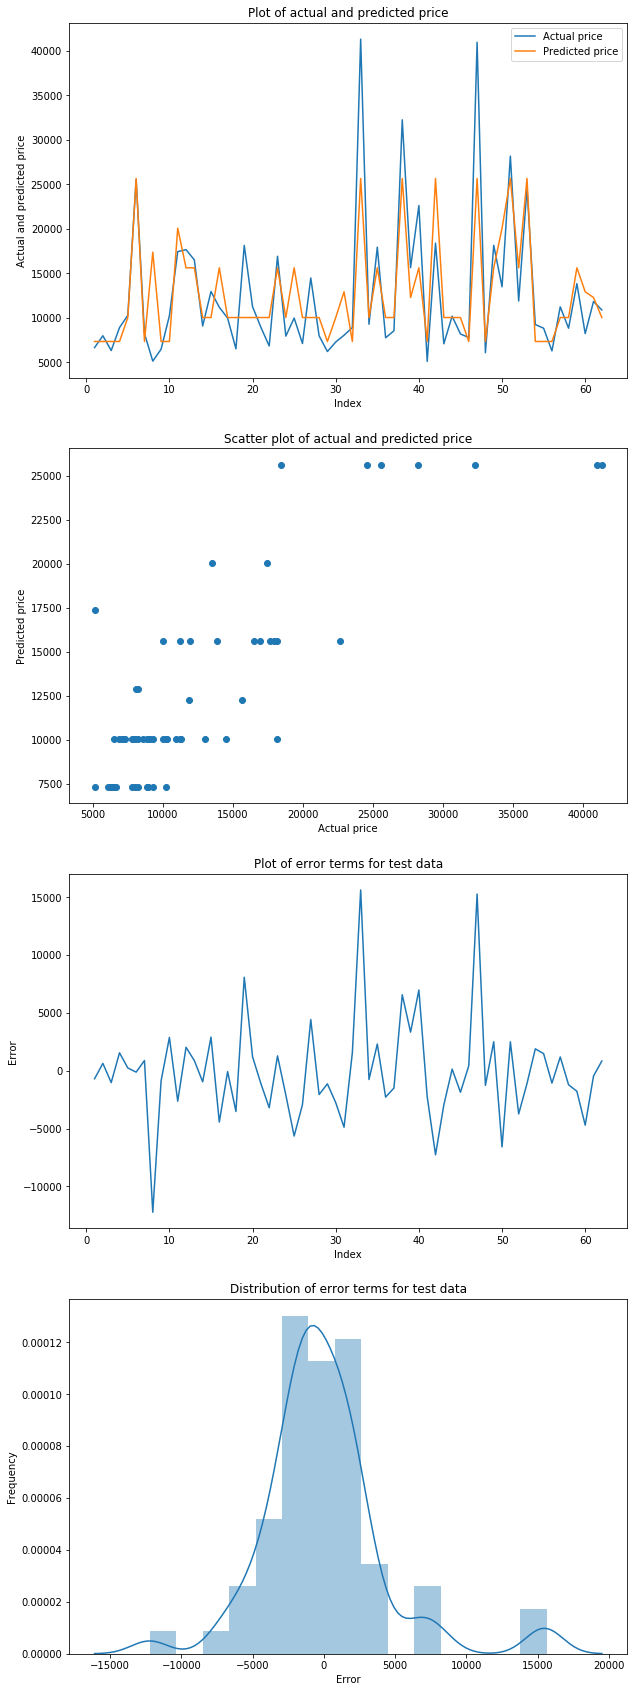

In [0]:
c=[i for i in range(1,len(X_test)+1)]
fig1=plt.figure(1, figsize=(10,30))
plt.subplot(411)
ax1=plt.plot(c, y_test, label='Actual price')
ax2=plt.plot(c,y_pred, label='Predicted price')
plt.xlabel('Index')
plt.ylabel('Actual and predicted price')
plt.title('Plot of actual and predicted price')
plt.legend()

plt.subplot(412)
plt.scatter(y_test,y_pred)
plt.xlabel('Actual price')
plt.ylabel('Predicted price')
plt.title('Scatter plot of actual and predicted price')

plt.subplot(413)
plt.plot(c,y_test-y_pred)
plt.xlabel('Index')
plt.ylabel('Error')
plt.title('Plot of error terms for test data')

plt.subplot(414)
sns.distplot(y_test-y_pred)
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title('Distribution of error terms for test data')
plt.show()

Printing RMSE

In [0]:
print('RMSE: ', np.sqrt(mean_squared_error(y_test,y_pred)))

RMSE:  4355.13010182


## 4. Conclusions

The price of a car in US market mainly depends on the following parameters

In [0]:
list(lm_12.params.index[1:])

['drivewheel_rwd',
 'enginetype_rotor',
 'cylindernumber_four',
 'cylindernumber_twelve',
 'fuelsystem_2bbl']

The parameters/linear weights for each of these independent variables are as follows

In [0]:
lm_12.params

const                    13290.872448
drivewheel_rwd            5583.621504
enginetype_rotor        -13368.310936
cylindernumber_four     -10032.909139
cylindernumber_twelve    10336.689064
fuelsystem_2bbl          -2691.303658
dtype: float64